##### Week 4 Homework

The aim is to compare LogReg OvR, LogReg OvO, Mulitnomial Regression and Decision Tree performances

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("IRIS.csv")

# Preprocessing
# Encode the target variable
from sklearn.preprocessing import StandardScaler, LabelEncoder

if df["species"].dtype == 'object':
    le = LabelEncoder()
    df["species"] = le.fit_transform(df["species"])

pd.unique(df["species"])


array([0, 1, 2])

In [2]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

# compute class weights for each instance
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(df["species"]), y = df["species"])
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(df["species"]), class_weights)}

# compute sample weights for each instance
sample_weights = compute_sample_weight(class_weight = class_weights_dict, y = df["species"]) 

class_weights_dict 

{np.int64(0): np.float64(0.86),
 np.int64(1): np.float64(0.86),
 np.int64(2): np.float64(1.4827586206896552)}

In [ ]:
# Split features and target variable
from sklearn.model_selection import train_test_split
 
X = df.drop("species", axis = 1)
y = df["species"]

# feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train-test split (with scaled data and sample weights)
X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(X_scaled, y, sample_weights, test_size = 0.3, stratify = y, random_state = 42)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

# LogReg (OvR) with sample weight balancing
from sklearn import set_config

# Enable metadata routing for OVRClassifier, so that sample weights are not ignored
set_config(enable_metadata_routing = True)

ovr = OneVsRestClassifier(LogisticRegression(class_weight = class_weights_dict, max_iter = 10000)) 
ovr.estimator.set_fit_request(sample_weight = True)  # explicitly request sample_weight
ovr.fit(X_train, y_train, sample_weight = sw_train) # train model with sample weights
y_pred_ovr = ovr.predict(X_test)


In [24]:
# LogReg (OvO) with sample weight balancing

ovo = OneVsOneClassifier(LogisticRegression(class_weight = class_weights_dict, max_iter = 10000)) 
ovo.estimator.set_fit_request(sample_weight = True)  # explicitly request sample_weight
ovo.fit(X_train, y_train, sample_weight = sw_train) # train model with sample weights
y_pred_ovo = ovo.predict(X_test)


In [20]:
# Decision Tree with sample weight balancing 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

dt = DecisionTreeClassifier(random_state = 42)
dt.fit(X_train, y_train)

# hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state = 42), param_grid, cv = 5)
grid_search.fit(X_train, y_train)

print("Best Parameters for Decision Tree:", grid_search.best_params_)
best_dt = grid_search.best_estimator_
y_pred_bestdt = best_dt.predict(X_test)

Best Parameters for Decision Tree: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


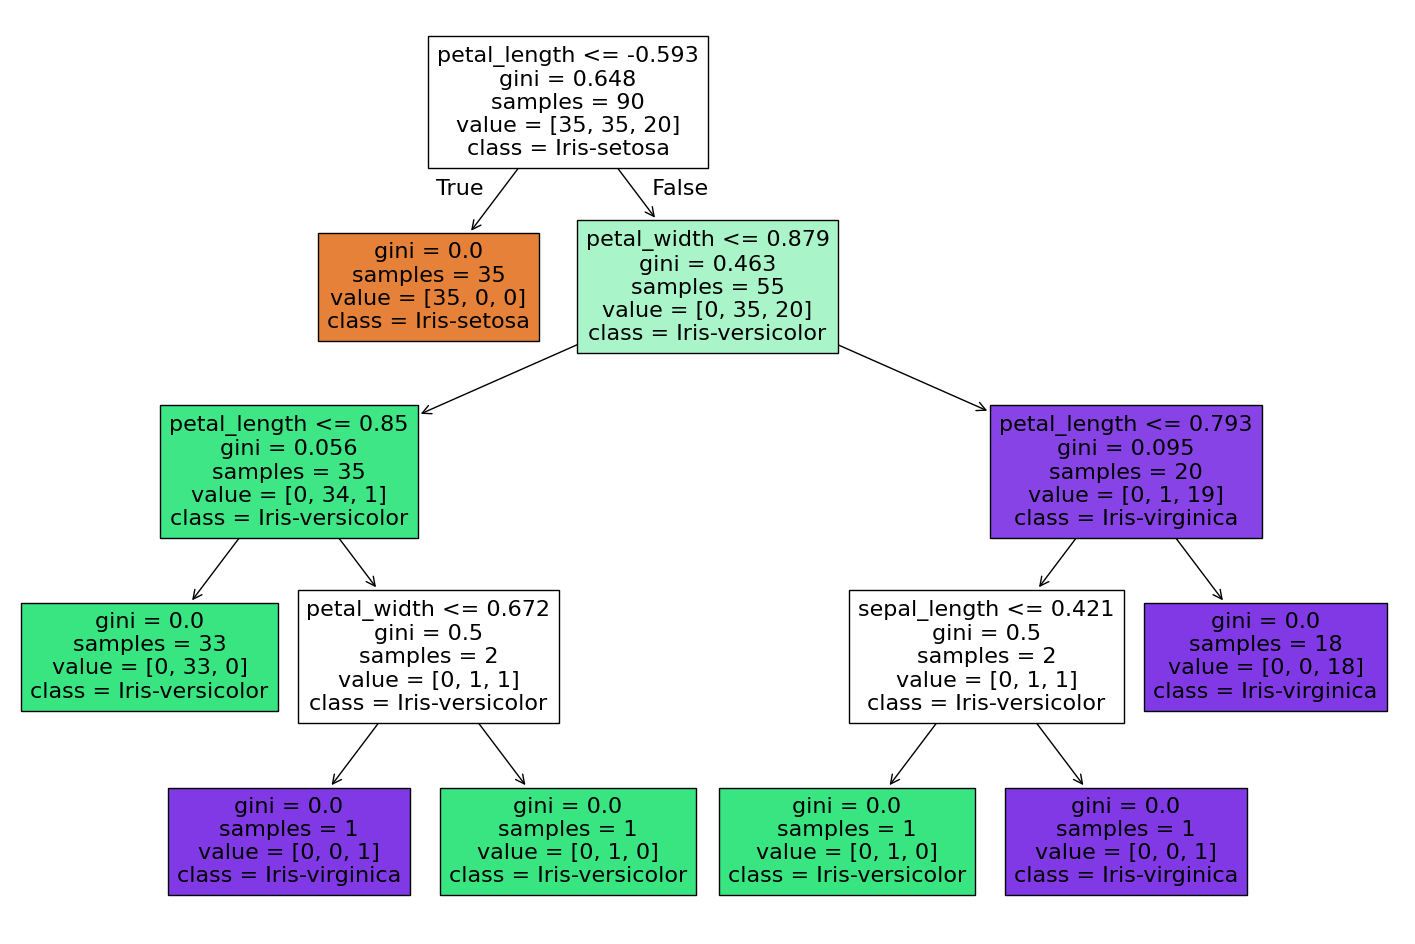

In [21]:
plt.figure(figsize = (18,12)) # visualise tree
plot_tree(dt, filled = True, feature_names = X.columns, class_names = le.classes_)
plt.show()

In [37]:
# Softmax (multinomial) Regression
softmax = LogisticRegression(multi_class='multinomial', solver='lbfgs')
softmax.fit(X_train, y_train)
y_pred_soft = softmax.predict(X_test)


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [41]:
# Model Evaluation metrics 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score

def evaluate_model(name, model, X_test, y_true, y_pred, y_proba=None):
    results = {}

    print(f"=== {name} ===")

    results['Accuracy']  = accuracy_score(y_true, y_pred)
    results['Precision'] = precision_score(y_true, y_pred, average='macro')
    results['Recall']    = recall_score(y_true, y_pred, average='macro')
    results['F1']        = f1_score(y_true, y_pred, average='macro')

    print("Accuracy :", results['Accuracy'])
    print("Precision:", results['Precision'])
    print("Recall   :", results['Recall'])
    print("F1 Score :", results['F1'])

    if hasattr(model, "predict_proba"):
        print("Log Loss:", log_loss(y_true, y_proba))
        print("ROC AUC :", roc_auc_score(y_true, y_proba, multi_class='ovr'))
    else:
        print("Log Loss: Not available (predict_proba not supported)")
        print("ROC AUC : Not available (predict_proba not supported)")

    print("="*40)


evaluate_model("Logistic Regression OvR ", ovr, X_test, y_test, y_pred_ovr, ovr.predict_proba(X_test)) # Logistic Regression (OvR) balanced
evaluate_model("Logistic Regression OvO ", ovo, X_test, y_test, y_pred_ovo) # Logistic Regression (OvO) balanced
evaluate_model("Tuned Decision Tree Performance", best_dt, X_test, y_test, y_pred_bestdt, best_dt.predict_proba(X_test)) # Tuned Decision Tree balanced
evaluate_model("Softmax (multinomial) Regression", softmax, X_test, y_test, y_pred_soft, softmax.predict_proba(X_test))

=== Logistic Regression OvR  ===
Accuracy : 0.8461538461538461
Precision: 0.8666666666666667
Recall   : 0.8666666666666667
F1 Score : 0.8333333333333334
Log Loss: 0.3723517164331867
ROC AUC : 0.9706790123456791
=== Logistic Regression OvO  ===
Accuracy : 0.9487179487179487
Precision: 0.9407407407407407
Recall   : 0.9407407407407407
F1 Score : 0.9407407407407407
Log Loss: Not available (predict_proba not supported)
ROC AUC : Not available (predict_proba not supported)
=== Tuned Decision Tree Performance ===
Accuracy : 0.9743589743589743
Precision: 0.9791666666666666
Recall   : 0.9629629629629629
F1 Score : 0.9696394686907022
Log Loss: 0.9419692453763359
ROC AUC : 0.9734567901234569
=== Softmax (multinomial) Regression ===
Accuracy : 0.9743589743589743
Precision: 0.9791666666666666
Recall   : 0.9629629629629629
F1 Score : 0.9696394686907022
Log Loss: 0.15615029695474328
ROC AUC : 1.0


### Overall Model Evaluation

General notes: As we applied sample weights, accuracy is not biased by class imbalance. Further, false positives and false negatives carry no extra cost here so accuracy is the most appropriate metric to prioritize. F1, Precision, and Recall are still useful but less critical.

Logistic Regression (OvR) performed the weakest overall, with accuracy of ~85% but delivered well calibrated probability estimates, as shown by its very low log loss (0.37). This indicates that the one-vs-rest strategy struggled with separating classes compared to other methods.

Logistic Regression (OvO) achieved much stronger accuracy (~95%), showing that one-vs-one decomposition helped improve separation, but it lacks probability outputs (so log loss and ROC AUC are not available).

Tuned Decision Tree performed very well (accuracy ~97%), with balanced precision, recall, and F1, and a good ROC AUC. This suggests that the model was able to capture non-linear class boundaries effectively.

Finally, Softmax Regression matched the Decision Tree with accuracy of ~97%, but with the lowest log loss and a perfect ROC AUC of 1.0, making it the best model.
